## Introduction to reinforcement learning

### Summary and setup

TBC - GitHub codespaces?

### Questions

- What is reinforcement learning?
- How can a computer "agent" learn?
- What are the strengths and weaknesses of some popular reinforcement learning techniques?

### Objectives

- Understand how to train an agent using three different approaches: SARSA, Q-learning and Monte-Carlo
- Learn how to use the gymnasium library to create a simple environment for the agent to learn from
- Visualise the impact that the different approaches to learning have on the behaviour of the agent

### Prerequisites

- TBC

### 1. Introduction

Reinforcement learning begins with a simulated agent and an environment for the agent to interact with. By mathematically assessing the responses it receives from the environment in response to the actions it takes, the agent learns to optimise its decision-making process by trial and error. 

It's a category of machine learning that has show great promise in domains including autonomous vehicle navigation, gaming, biotechnology, computer chip design, and nuclear fusion. It has roots in both psychology and control theory and although many of the key developments in reinforcement learning, for example Q-learning, are now decades-old, the field has undergone a transformation in its capabilities in recent years with the bringing together of reinforcement learning strategies and the power of deep learning and artificial neural networks.

In practice, reinforcement learning usually works by training an agent over repeated episodes, or a sequence of states, actions and rewards that continues until some terminal state is reached. 

This practical session will demonstrate what this means in the context of the gymnasium library's [cliff-walking environment](https://gymnasium.farama.org/environments/toy_text/cliff_walking/).

#### Imports

We begin by loading some python libraries and locally-saved functions that will help with this task. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import os
# from pathlib import Path
# import sys

# lib_dir = Path(os.getcwd()).parent / 'lib'
# sys.path.append(str(lib_dir))

# from agents_nt import MC_agent, TD_agent
# from utils_nt import plot_value, plot_returns, plot_explore

import gymnasium as gym
from IPython import display as ipythondisplay

import time    

### 2. Environment

Having loaded `gym`, we can build the environment with only one line of code. We initialise the environment's `render_mode` to be `rgb_array` to help us visualise the environnment later.

In [2]:
env = gym.make('CliffWalking-v0', render_mode ='rgb_array')

From the environment's documentation, we know that it consists of a two-dimensinal grid of 4 rows and 12 columns, making a total of 48 possible locations - or states - for our agent to be located at. Our agent can move horizontally or vertically but not diagonally, so has four potential actions it can take at any one step. 

We store these values for usage later.

In [3]:
n_states = 48
grid_shape = (4, 12) # (Rows, columns)

n_actions = 4
action_lookup = {0: 'U', 1: 'R', 2: 'D', 3: 'L'} # Up, right, down, left

### 3. Temporal difference agents

Our initial approach will be to create temporal difference agents, which are so-called because they update their understanding of the environment at every time step (in contrast to other types of agent which perform the udpate at the end of each episode, which we will get to later).

Below is some code to create and train two types of temporal difference agent: SARSA (on policy) and Q-learning (off-policy). 

Both of these learn a tabular Q function which works well with out simple environment because it has discrete states and discrete actions. 

First we will walk through the creation of a SARSA agent and then modify it slightly to produce a Q-learning agent. 

We will then demonstrate training these agents on the cliff-walking environment and analyse the difference in behavious produced by the on-policy and off-policy learning methods. 

#### - SARSA agent

First we will initialise our agent as a Python class, with some important information about how the agent will behave and what choices it can take at each time step set as instance variables. 

The agent will have access to its environment `env`, with the variables `n_states` and `n_actions` are the number of possible states and actions associated with that environment, detailed above. 

The `gamma` (discount factor), `alpha` (learning rate) variables play an important role in determining how the agent learns, and by default we set these to sensible values. 

Because both the state and action spaces are discrete and relitively small we can learn a tabular Q function where each state, action pair is simply an element in the table. Therefore we initialise our Q function (`Q_func`) as a numpy table of zeros of size `(n_states, n_actions)`.

In [4]:
class TD_agent():
    def __init__(self, env, n_states, n_actions, gamma=0.95, alpha=0.01):
        self.env = env
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.Q_func = np.zeros((n_states, n_actions))

#### Policy

So far, our agent knows how many states it may be in and how many actions it may be able to take. But what it really needs is a **policy** - a means of determining which action to take based on the state it is in. 

We will define this policy as the "epsilon-greedy policy". This code uses the `np.random.random` and `np.random.choice` functions to take a random action with probability determined by the `explore_rate` paramater (also known as epsilon). 

With probability `1 - explore_rate` we take the action that has the highest value in the current state according to our Q function.

This policy is designed to balance random exploration of the environment with exploitation of knowledge already gathered about the environment, and the `explore_rate` is typically reduced as the agent gets to know the environment better. 

In [5]:
def epsilon_greedy_policy(self, state, explore_rate):
    """Choose an action based on the agent's value function and the current explore rate

    Args:
        state (int): the current state given by the environment
        explore_rate (float): the probability of taking a random action

    Returns:
        int: the action to be taken
    """
    if np.random.random() < explore_rate:
        # In this case the agent will randomly choose an integer from 0 to 3
        action = np.random.choice(range(self.n_actions))
    else:
        # Otherwise the agent chooses the action that has the highest value 
        # corresponding to its state in the Q function
        action = np.argmax(self.Q_func[state])
    return action

We add this function to the Python class:

In [6]:
TD_agent.policy = epsilon_greedy_policy

But a key ingredient is missing. Our agent needs to be able to learn what values to put in its Q function. At the moment it has nothing but zeros!

Our first update rule - known as SARSA - takes a transition, which contains the states, actions and reward relevant to a single time_step and the `done` variable which tells us weather the current transition is the last one in the current episode. The `done` variable will be `False` if the episode has not finished and `True` if it has. 

We then update our Q function, with the magnitude of the update being dictated by the agent's learning rate `alpha`. 

Refer back to the SARSA update formula in the slides to see how we have translated the maths into code. 

The `(1 - done)` term in the update rule means that the estimate of the future return is not incorporated if the episode finishes on this transition (if the episode finishes there can be no additional return in the future!). This is because in Python `True` and `False` are aliases for the integers 1 and 0 in mathematical operations such as multiplication. 

In [7]:
def SARSA_update(self,transition):
    """Update the agent's Q function based on the experience in transition
    
    Args:
        transition (int, int, float, int, int, bool): values to define a SARSA transition
    """

    # First we unpack the SARSA data from the transition:
    state, action, reward, next_state, next_action, done = transition

    # Then we use this data to update the Q function:
    value_of_current_state = self.Q_func[state, action]
    discounted_value_of_next_state = self.gamma * self.Q_func[next_state, next_action] * (1 - done)
    self.Q_func[state, action] += self.alpha * (reward + discounted_value_of_next_state - value_of_current_state)

TD_agent.update_Q = SARSA_update

#### Training loop

At last, we're ready to train the agent! We create a helper function that takes an agent and an environment as arguments, then loops over a pre-determined number of episodes trying to define an optimal policy. 

As you read through the code below, try to answer the following questions:

* Where is the agent's policy queried to get the next action?
* Where is the action applied to the environment?
* Where is the state, action, reward, next_state, next_action constructed?

In [11]:
def run_episode(self, explore_rate):
    episode_reward = 0 # sum the reward we get this episode
    episode_transitions = [] # memory of all transitions seen in this episode
    done = False # has the episode finished?
    
    state, prob = self.env.reset() # Reset env to initial state

    action = self.policy(state, explore_rate) # Initialise the agent

    while not done: # run the episode until a terminal state reached
        next_state, reward, done, info, prob = self.env.step(action) # take an action and get the resulting state from the env
        next_action = self.policy(next_state, explore_rate) # get the next action to apply from agent's policy
        transition = (state, action, reward, next_state, next_action, done) # create the SARSA transition
        episode_transitions.append(transition) # add to the memory
        self.update_Q(transition) # use the transition values to update the agent's Q function

        # Prepare for next step:
        state = next_state
        action = next_action

        # Keep track of cumulative reward:
        episode_reward += reward
    
    self.latest_episode_transitions = episode_transitions

    return episode_reward

TD_agent.run_episode = run_episode

def train_TD_agent(self, explore_rate, n_episodes=10001):
    training_returns = []
    for episode in range(n_episodes): # For each episode:
        episode_reward = self.run_episode(explore_rate)
        training_returns.append(episode_reward)
        if episode % 1000 == 0: # print results of current episode
            print('episode:', episode, ', explore_rate:', explore_rate, ', return:', episode_reward)
    return training_returns

TD_agent.train = train_TD_agent
        

Just one more thing: we'd like to be able to visualise the learned behaviour of the agent. We can do this using the transitions we stored in the `latest_episode_transitions` variable:

In [12]:
def show_env(self):
    plt.imshow(self.env.render())
    time.sleep(0.1)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

TD_agent.show_env = show_env

def display_learned_behaviour(self):
    self.run_episode(explore_rate=0)
    state, prob = self.env.reset()
    self.show_env()
    for transition in self.latest_episode_transitions:
        action = transition[1]
        self.env.step(action)
        self.show_env()
    ipythondisplay.clear_output(wait=True)

TD_agent.display_learned_behaviour = display_learned_behaviour

Now we can train our SARSA agent with an explore rate of 0.05.

In [13]:
SARSA_agent = TD_agent(env, n_states, n_actions)
print('TRAINING')
training_returns = SARSA_agent.train(explore_rate=0.05) # train the agent



TRAINING
episode: 0 , explore_rate: 0.05 , return: -109
episode: 1000 , explore_rate: 0.05 , return: -54
episode: 2000 , explore_rate: 0.05 , return: -39
episode: 3000 , explore_rate: 0.05 , return: -120
episode: 4000 , explore_rate: 0.05 , return: -17
episode: 5000 , explore_rate: 0.05 , return: -15
episode: 6000 , explore_rate: 0.05 , return: -17
episode: 7000 , explore_rate: 0.05 , return: -15
episode: 8000 , explore_rate: 0.05 , return: -15
episode: 9000 , explore_rate: 0.05 , return: -17
episode: 10000 , explore_rate: 0.05 , return: -19


Now we run a test episode with an explore rate of 0 so that we can test the agents learned policy.

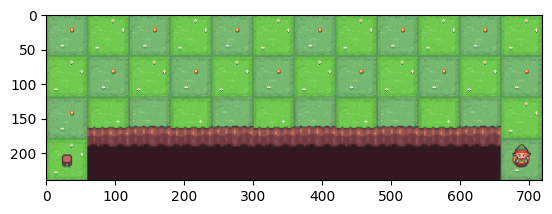

In [14]:
SARSA_agent.display_learned_behaviour()


Now we can plot the Q function which shows us the stat-action values the agent has learned and the agents learned policy overlaid on the state-value plot. 

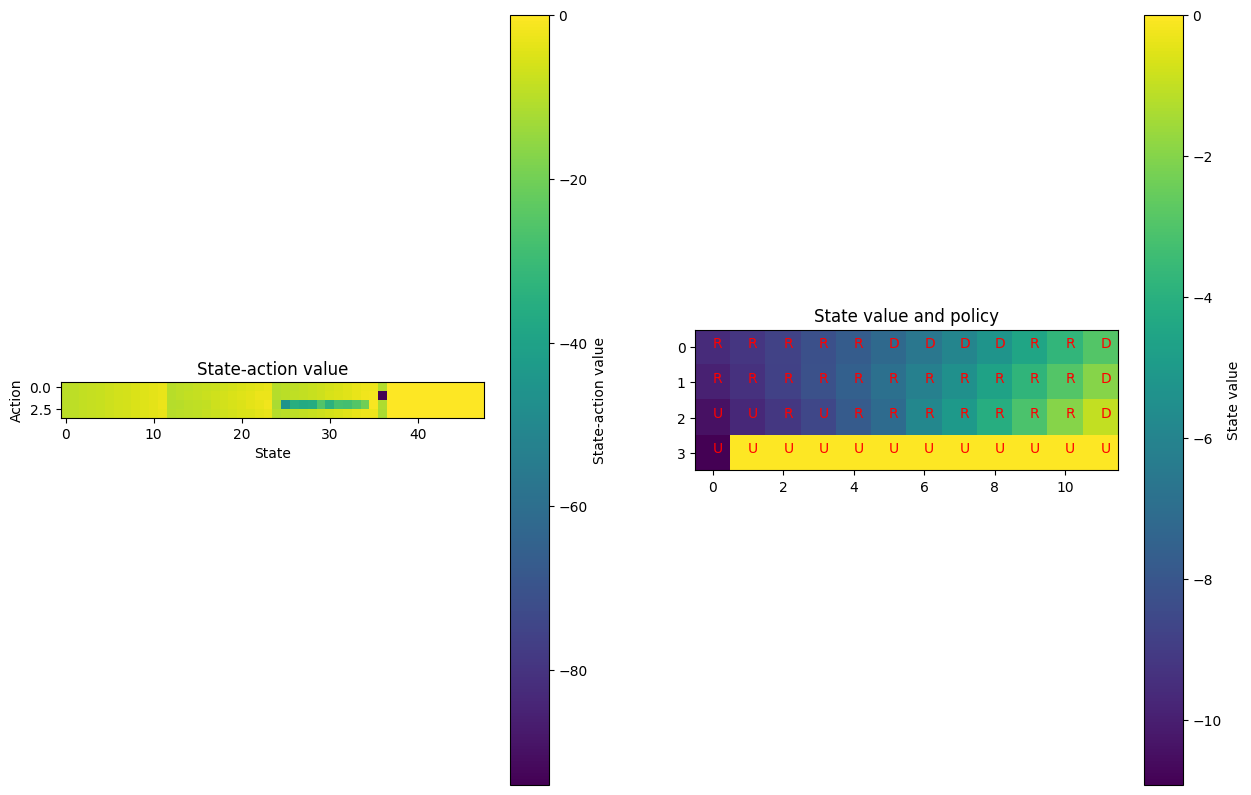

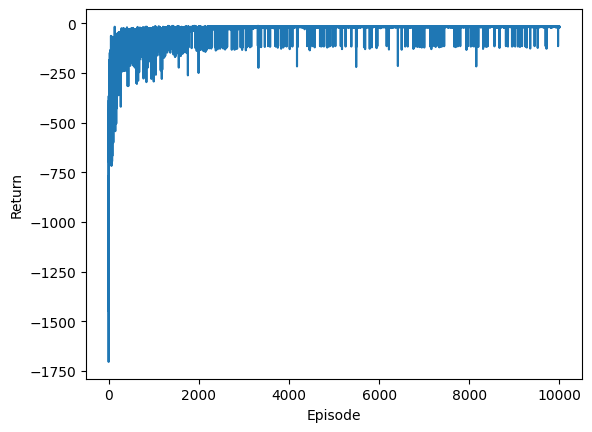

In [10]:
# plot value function, policy and return 
plot_value(SARSA_agent.Q_func, grid_shape, p_map) # plot the value function and policy 
plot_returns(returns)

### Q-learning agent

We will now modify our agent so that we are doing Q learning. How is this update rule different from the SARSA one above?

In [11]:
def Q_update(self,transition):
    '''
    updates the agents value function based on the experience in transition
    :param transition:
    :return:
    '''

    state, action, reward, next_state, next_action, done = transition

    self.Q_func[state, action] += self.alpha * (reward + self.gamma * np.max(self.Q_func[next_state]) * (1 - done) - self.Q_func[state, action])

TD_agent.update_Q = Q_update



In [12]:
Q_agent = TD_agent(n_states, n_actions)
print('TRAINING')
returns = train_agent(Q_agent, env, explore_rate = 0.05) # train the agent

TRAINING
episode: 0 , explore_rate: 0.05 , return: -135
episode: 1000 , explore_rate: 0.05 , return: -26
episode: 2000 , explore_rate: 0.05 , return: -13
episode: 3000 , explore_rate: 0.05 , return: -13
episode: 4000 , explore_rate: 0.05 , return: -13
episode: 5000 , explore_rate: 0.05 , return: -15
episode: 6000 , explore_rate: 0.05 , return: -14
episode: 7000 , explore_rate: 0.05 , return: -13
episode: 8000 , explore_rate: 0.05 , return: -17
episode: 9000 , explore_rate: 0.05 , return: -14
episode: 10000 , explore_rate: 0.05 , return: -124


In [13]:
# run a test episode
print()
print('TEST EPISODE')
r = train_agent(Q_agent, env, n_episodes=1, explore_rate=0, display=False, simple_text = True) # run a test episode to get the learned behaviour with no exploring



TEST EPISODE
episode: 0 , explore_rate: 0 , return: -13


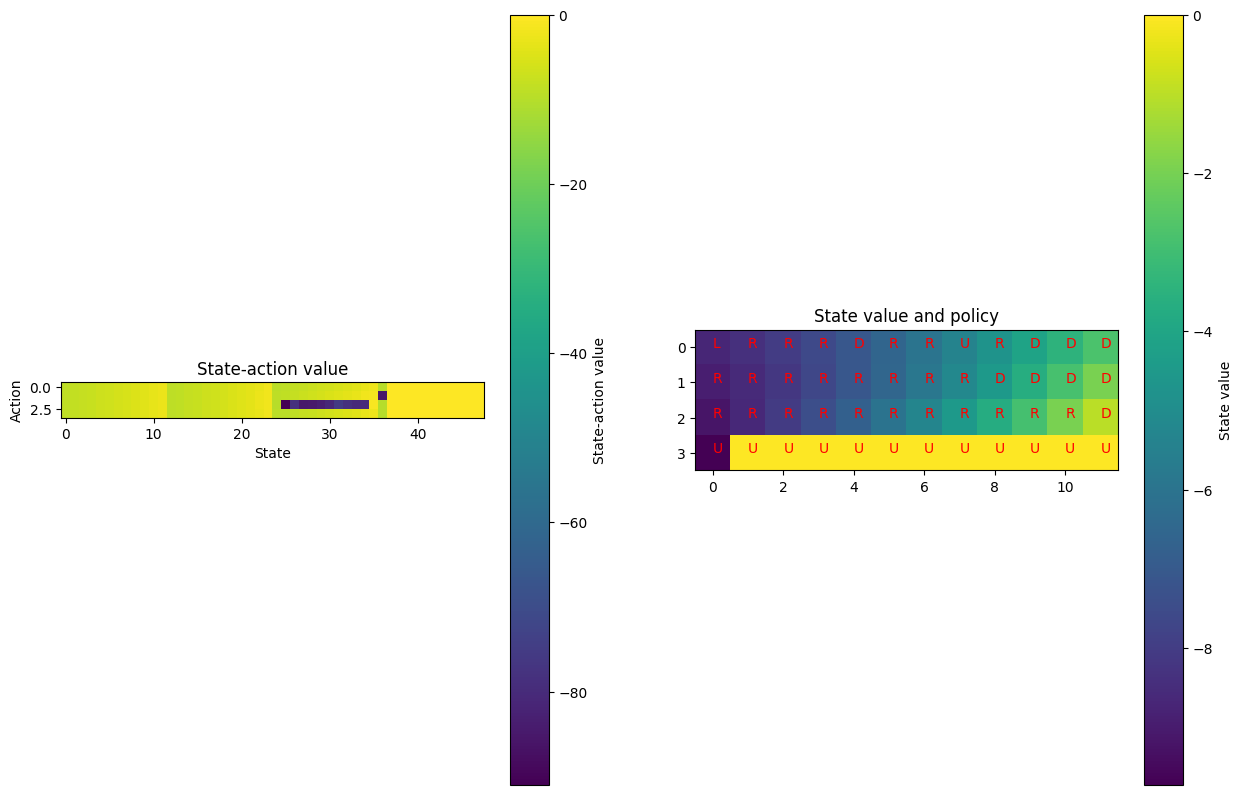

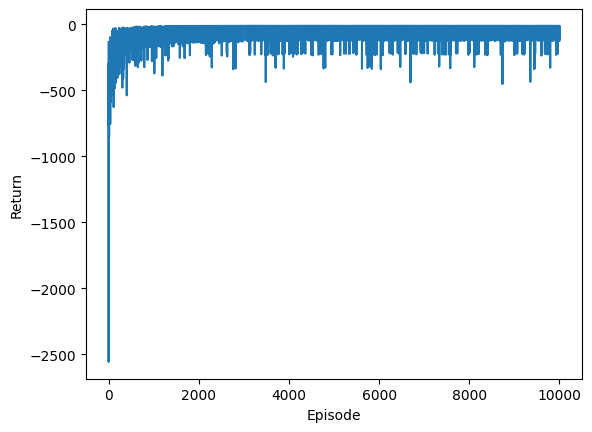

In [14]:
# plot value function, policy and return 
plot_value(Q_agent.Q_func, grid_shape, action_lookup) # plot the value function and policy 
plot_returns(returns)

### See if you can answer these questions
1. What is the key difference in the update rules of the Q learning and SARSA agents? 
2. Train both agents
3. What is the final return (in the test episode) of the Q learning and SARSA agents?
4. What differences do you notice in the learned behaviours? Why are they different?
5. What does the region of the state-action plot with very low value correspond to?
6. Try increasing the explore rate for each agent, e.g. to 0.3. What is the effect on the behaviour of each agent. Remember to run the relevant cell to set the agents update rule to either Q learning or SARSA

# 2. Monte carlo agent
1. Try and train the monte carlo agent. If it gets stuck try restarting the cell a few times, training could take around 5-10 minutes.
2. Have a look at the train_agent function in the first cell. Can you see where the agents Q-functions are updated, why is the monte-carlo updated in a different place to the temporal difference agents?
3. Sometimes MC can get stuck in an episode for a long time, why is this?
4. Does the learned policy look more like the SARSA or Q-learning agent's, why?

In [15]:
# train the agent 
M_agent = MC_agent(n_states, n_actions)
returns = train_agent(M_agent, env,n_episodes=10001,  monte_carlo=True, explore_rate=0.3)


episode: 0 , explore_rate: 0.3 , return: -15068
episode: 1000 , explore_rate: 0.3 , return: -131
episode: 2000 , explore_rate: 0.3 , return: -2066
episode: 3000 , explore_rate: 0.3 , return: -121
episode: 4000 , explore_rate: 0.3 , return: -433
episode: 5000 , explore_rate: 0.3 , return: -30
episode: 6000 , explore_rate: 0.3 , return: -250
episode: 7000 , explore_rate: 0.3 , return: -218
episode: 8000 , explore_rate: 0.3 , return: -83
episode: 9000 , explore_rate: 0.3 , return: -27
episode: 10000 , explore_rate: 0.3 , return: -37


In [16]:
# run test episode
r = train_agent(M_agent, env, n_episodes=1, explore_rate=0, display=False, monte_carlo=True, simple_text = True)


KeyboardInterrupt: 

In [ ]:
#plot value function, policy and return
plot_value(M_agent.Q_func, grid_shape, action_lookup)
plot_returns(returns)